#### What is the depth of the ESACCI sm data?

What is the maximum depth of the observed surface soil moisture?

The ESA CCI SM data set is representative of the first few centimeters of soil (~0-5cm). An exact number cannot be determined as multiple sensors are combined in the data products. The depth depends on the sensors that are actually used at each point in time and their characteristics (active/passive sensor, measurement frequency, etc).

In [1]:
%who

Interactive namespace is empty.


In [2]:
import xarray as xr
import numpy as np
import geopandas as gpd
import datetime
import matplotlib

# getting the spatial plotting function from another directory
import sys
new_path = '/home/566/ad9701/drought_probability/final_code_AU/'
if new_path not in sys.path:
    sys.path.append(new_path)
import validation_functions as myfuncs

In [3]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/sm_data/'
sm_mon_file = 'esacci_monthly_1979_2020.nc'
sm_uncert_mon_file = 'esacci_sm_uncertainty_monthly_1979_2020.nc'

ds_sm = xr.open_dataset(data_dir + sm_mon_file)
ds_sm_uncert = xr.open_dataset(data_dir + sm_uncert_mon_file)

In [5]:
# data for the drought period
time_slice = slice('2016-12-01', '2020-12-31')
da_sm = ds_sm['sm'].sel(time = time_slice)
da_sm_uncert = ds_sm_uncert['sm_uncertainty'].sel(time = time_slice)

# the monthly climatology from long-term data
time_slice = slice('1981-01-01', '2020-05-31')
da_sm_lt_monClim = ds_sm['sm'].sel(time = time_slice).groupby('time.month').mean('time')
da_sm_monAnom = da_sm.groupby('time.month') - da_sm_lt_monClim
da_sm_uncert_lt_monClim = ds_sm_uncert['sm_uncertainty'].sel(time = time_slice).groupby('time.month').mean('time')

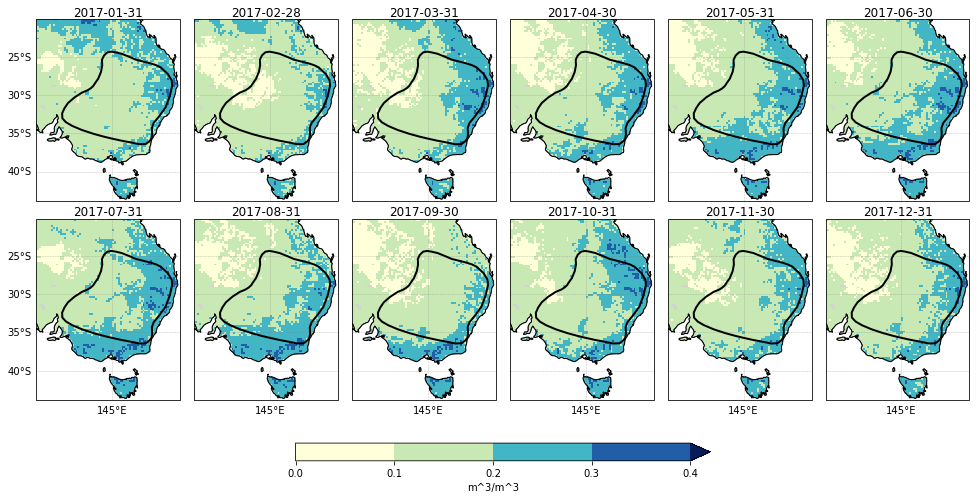

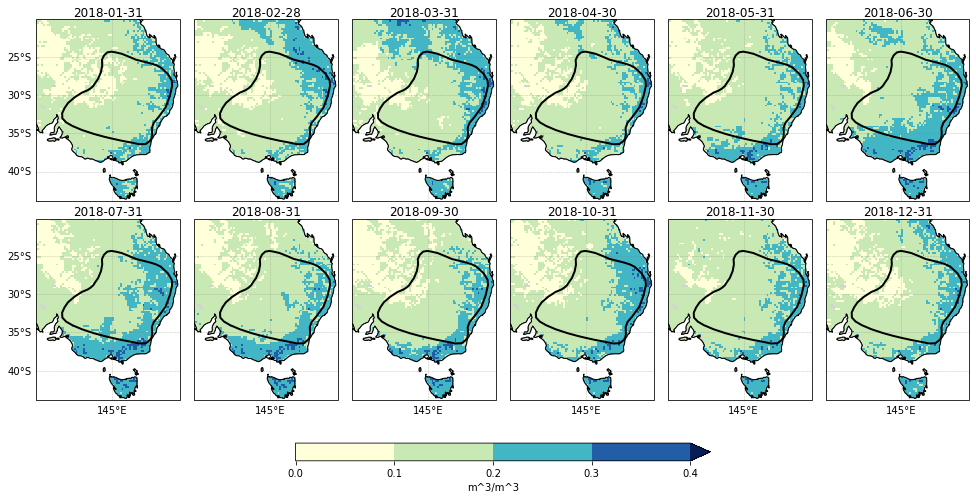

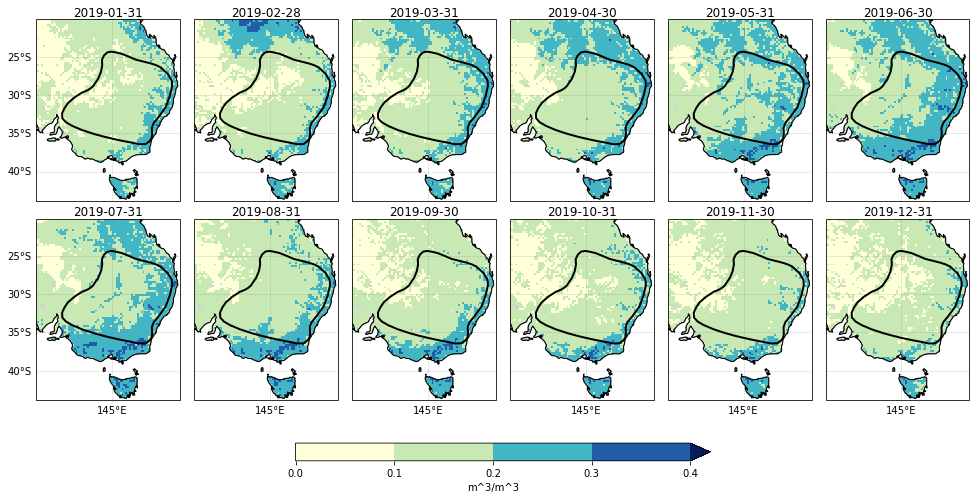

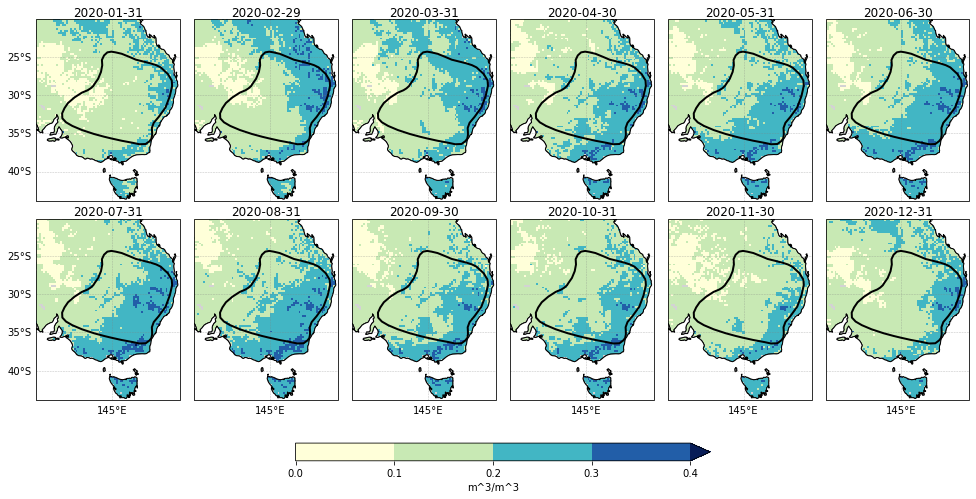

In [12]:
out_dir = 'figures/drought_2017to2020/sm/'
figname_prefix = 'sm_esacci_monMean'

sh_file = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp'

current_cmap = matplotlib.cm.get_cmap("YlGnBu").copy()
current_cmap.set_bad(color='lightgrey')

# only the southeast
lat_slice_small = slice(-20, -44)
lon_slice_small = slice(135, 154)

for year in [2017, 2018, 2019, 2020]:
    da_year = da_sm.sel(time = str(year), lat=lat_slice_small, lon=lon_slice_small)
    plot_list = [da_year.isel(time = i) for i in range(len(da_year.time.values))] 
    
    # find the months for which the values are missing & place an empty data array there
    mon_array = np.array(range(1, 13))
    nanInd = [x not in da_year['time.month'].values for x in mon_array]
    for i in range(len(nanInd)):
        if nanInd[i]:
            da_temp = da_nan.sel(lat=lat_slice_small, lon=lon_slice_small).assign_coords({'time':datetime.datetime(year,i+1,15)})
            plot_list.insert(i, da_temp)
    
    subplot_title = [np.datetime_as_string(x.time.values, unit='D') for x in plot_list]
    for i in range(len(nanInd)):
        if nanInd[i]:
            subplot_title[i] = np.datetime_as_string(plot_list[i].time.values, unit='M') + ', missing'

    levels = [0, 0.1, 0.2, 0.3, 0.4]
    out_figname = figname_prefix + '_' + str(year)
    myfuncs.draw_pcolormesh_Npanels(plot_list, cmap = current_cmap, ncols = 6, nrows = 2, panel_width=2.4, panel_height=4.1, levels=levels, 
                                    subplot_title = subplot_title, shapefile = sh_file, shapefile_color = 'black',
                                    out_dir = out_dir, out_figname = out_figname, cbar_label='m^3/m^3', cbar_extend='max')

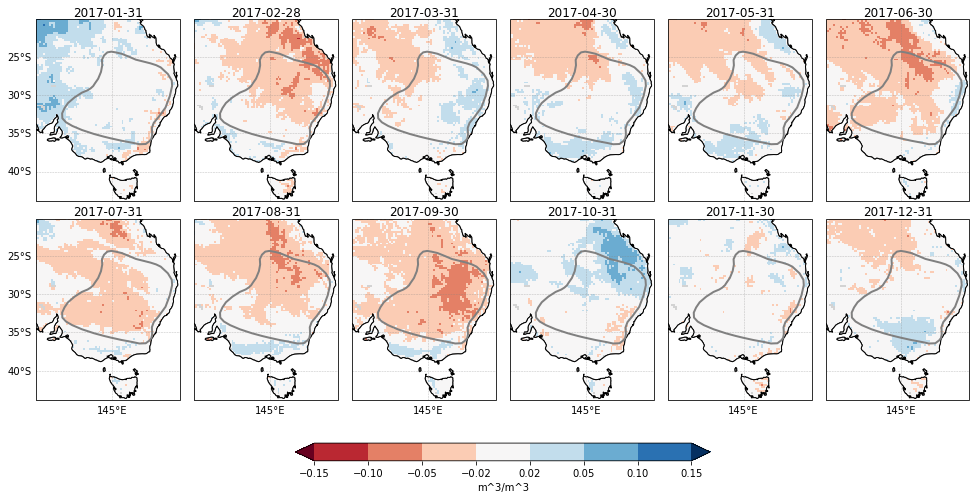

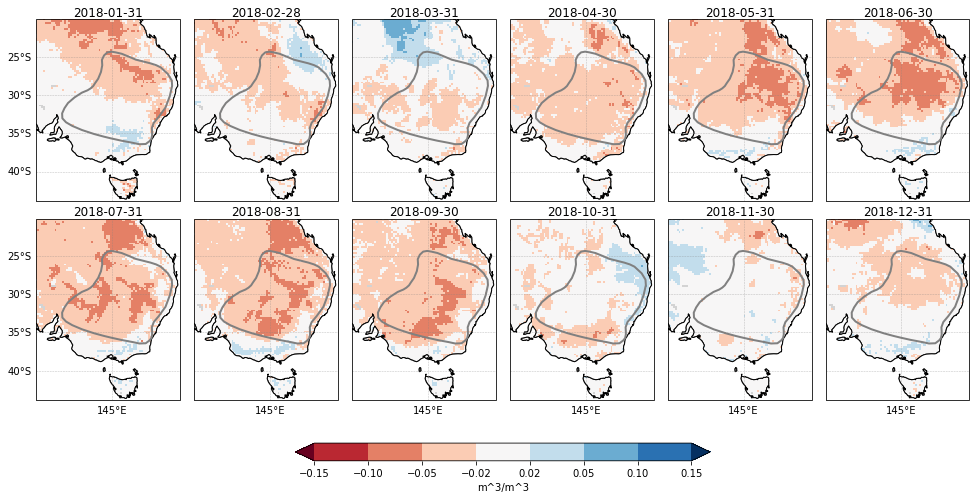

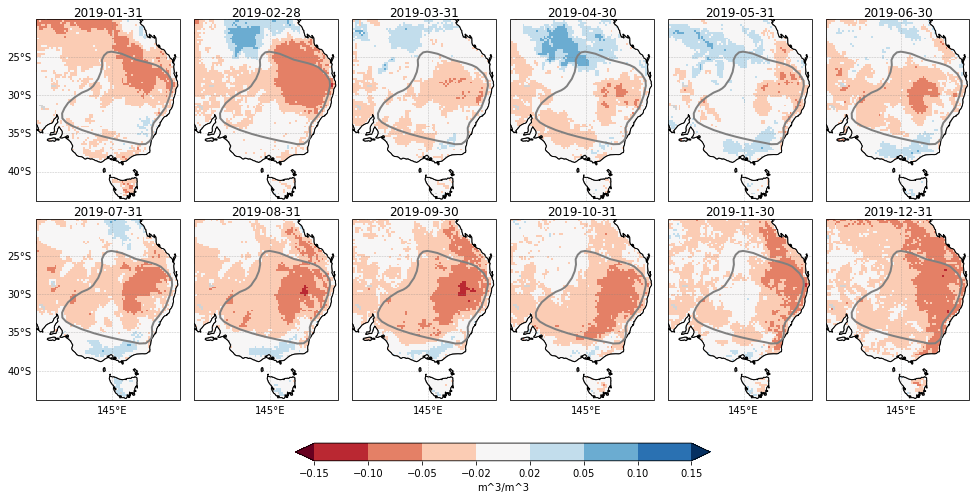

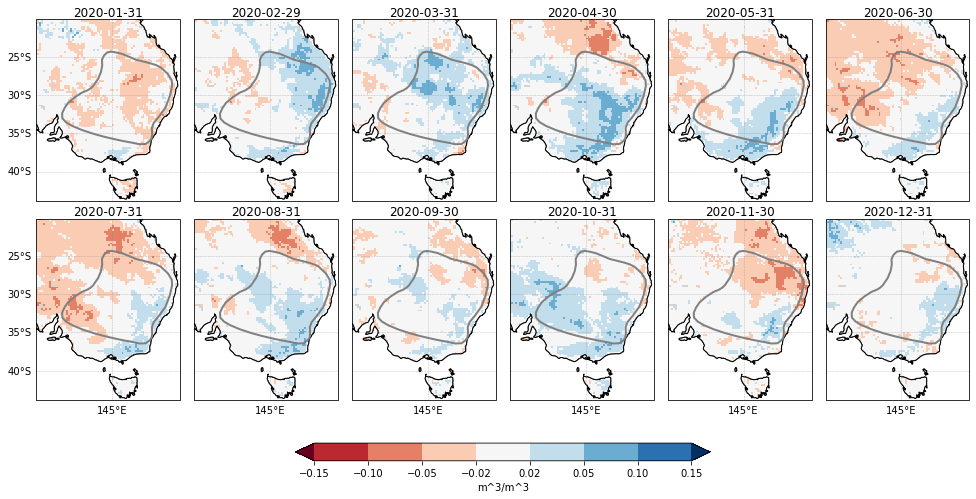

In [5]:
out_dir = 'figures/drought_2017to2020/sm/'
figname_prefix = 'sm_esacci_anomalies_fromMonClim_v1'

sh_file = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp'

current_cmap = matplotlib.cm.get_cmap("RdBu").copy()
current_cmap.set_bad(color='lightgrey')

# only the southeast
lat_slice_small = slice(-20, -44)
lon_slice_small = slice(135, 154)

for year in [2017, 2018, 2019, 2020]:
    da_year = da_sm_monAnom.sel(time = str(year), lat=lat_slice_small, lon=lon_slice_small)
    plot_list = [da_year.isel(time = i) for i in range(len(da_year.time.values))] 
    
    # find the months for which the values are missing & place an empty data array there
    mon_array = np.array(range(1, 13))
    nanInd = [x not in da_year['time.month'].values for x in mon_array]
    for i in range(len(nanInd)):
        if nanInd[i]:
            da_temp = da_nan.sel(lat=lat_slice_small, lon=lon_slice_small).assign_coords({'time':datetime.datetime(year,i+1,15)})
            plot_list.insert(i, da_temp)
    
    subplot_title = [np.datetime_as_string(x.time.values, unit='D') for x in plot_list]
    for i in range(len(nanInd)):
        if nanInd[i]:
            subplot_title[i] = np.datetime_as_string(plot_list[i].time.values, unit='M') + ', missing'

    levels = [-0.15, -0.1, -0.05, -0.02, 0.02, 0.05, 0.1, 0.15]
    out_figname = figname_prefix + '_' + str(year)
    myfuncs.draw_pcolormesh_Npanels(plot_list, cmap = current_cmap, ncols = 6, nrows = 2, panel_width=2.4, panel_height=4.1, levels=levels, 
                                    subplot_title = subplot_title, shapefile = sh_file, shapefile_color = 'grey',
                                    out_dir = out_dir, out_figname = out_figname, cbar_label='m^3/m^3') #, cbar_extend='max')

### Area mean

In [6]:
# get a region mask using the drought focus region shapefile
import regionmask

# read in the focus region shapefile
drought_focusReg = gpd.read_file('/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp')

# # create a mask of the polygon for the lat-long values in ds. The mask would contain '0' inside the region; nan otherwise
# da_mask_zeros = regionmask.mask_geopandas(geodataframe = drought_focusReg, lon_or_obj = da_sm_monAnom.lon.values, lat = da_sm_monAnom.lat.values)
# # setting the points inside the region to 1
# da_mask = xr.where(da_mask_zeros == 0, 1, np.nan)

# # save the mask into a netcdf file
# out_file = '/g/data/w97/ad9701/drought_2017to2020/ESACCI_mask_drought_focusArea.nc'
# da_mask.to_netcdf(out_file)

# read mask from saved file
mask_file = '/g/data/w97/ad9701/drought_2017to2020/ESACCI_mask_drought_focusArea.nc'
ds_mask = xr.open_dataset(mask_file)
da_mask = ds_mask['mask']

In [7]:
da_sm_monAnom_masked = da_sm_monAnom*da_mask
da_sm_monAnom_regAvg = myfuncs.calc_areaAvg(da_sm_monAnom_masked)

da_sm_uncert_masked = da_sm_uncert*da_mask
da_sm_uncert_regAvg = myfuncs.calc_areaAvg(da_sm_uncert_masked)

da_sm_uncert_lt_monClim_mask = da_sm_uncert_lt_monClim*da_mask
da_sm_uncert_lt_monClim_regAvg = myfuncs.calc_areaAvg(da_sm_uncert_lt_monClim_mask)

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [11]:
da_time_bymon = np.array(pd.to_datetime(da_sm_monAnom_regAvg.time).to_period('M').to_timestamp().floor('D') + np.timedelta64(14, 'D'))
da_sm_monAnom_regAvg = da_sm_monAnom_regAvg.assign_coords({'time': da_time_bymon})

da_time_bymon = np.array(pd.to_datetime(da_sm_uncert_regAvg.time).to_period('M').to_timestamp().floor('D') + np.timedelta64(14, 'D'))
da_sm_uncert_regAvg = da_sm_uncert_regAvg.assign_coords({'time': da_time_bymon})

Text(0, 0.5, 'm$^3$/m$^3$')

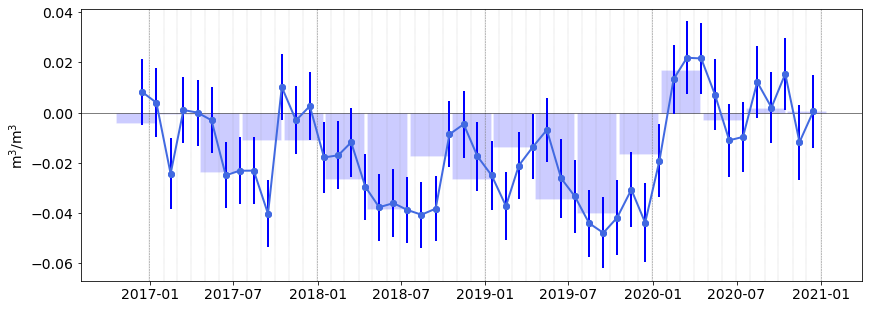

In [12]:
out_dir = 'figures/drought_2017to2020/sm/'

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

array_time = da_sm_monAnom_regAvg.resample(time="QS-DEC").mean().time.values.astype('datetime64[D]')
array_val = da_sm_monAnom_regAvg.resample(time="QS-DEC").mean().values
plt.bar(array_time, array_val, width=85, edgecolor='white', color='blue', alpha=0.2)

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
# plt.errorbar(da_sm_monAnom_regAvg.time.values, da_sm_monAnom_regAvg.values, yerr=da_sm_uncert_regAvg.values, fmt='o', color='royalblue',
#              ecolor='lightsteelblue', elinewidth=3, capsize=0)
plt.errorbar(da_sm_monAnom_regAvg.time.values, da_sm_monAnom_regAvg.values, yerr=da_sm_uncert_regAvg.values, fmt='o', color='royalblue',
             ecolor='blue', elinewidth=2, capsize=0)
plt.plot(da_sm_monAnom_regAvg.time.values, da_sm_monAnom_regAvg.values, color="royalblue", marker="o", linewidth=2)


plt.xlabel('')
plt.ylabel('m$^3$/m$^3$')

# fig.savefig(out_dir + 'areaAvg_ESACCI_anom_from_monClim_600dpi.png', bbox_inches='tight', dpi = 600)
# fig.savefig(out_dir + 'areaAvg_ESACCI_anom_from_monClim.pdf', bbox_inches='tight', format = 'pdf')

In [29]:
da_sm_monAnom_regAvg.resample(time="QS-DEC").mean()

<xarray.DataArray (time: 17)>
array([-0.00403808, -0.00065948, -0.02373488, -0.01105118, -0.01073356,
       -0.02635674, -0.03847558, -0.01715705, -0.02655608, -0.01382855,
       -0.03450418, -0.04012784, -0.01656078,  0.01688224, -0.00283318,
        0.00193033,  0.00050656])
Coordinates:
  * time     (time) datetime64[ns] 2016-12-01 2017-03-01 ... 2020-12-01

In [28]:
array_val

array([-0.00403808, -0.00065948, -0.02373488, -0.01105118, -0.01073356,
       -0.02635674, -0.03847558, -0.01715705, -0.02655608, -0.01382855,
       -0.03450418, -0.04012784, -0.01656078,  0.01688224, -0.00283318,
        0.00193033,  0.00050656])

In [13]:
da_sm_lt_monClim_masked = da_sm_lt_monClim*da_mask
da_sm_lt_monClim_regAvg = myfuncs.calc_areaAvg(da_sm_lt_monClim_masked)

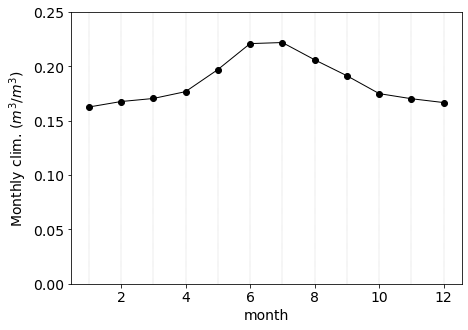

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(7,5)) #width, height

for xline in range(1, 13):
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)

plt.plot(da_sm_lt_monClim_regAvg.month.values, da_sm_lt_monClim_regAvg.values, color="black", marker="o", linewidth=1)
plt.xlabel('month')
plt.ylabel('Monthly clim. ($m^3$/$m^3$)')
plt.ylim((0, 0.25))

fig.savefig(out_dir + 'ESACCI_sm_monClim.png', bbox_inches='tight', dpi = 600)
fig.savefig(out_dir + 'ESACCI_sm_monClim.pdf', bbox_inches='tight', format = 'pdf')

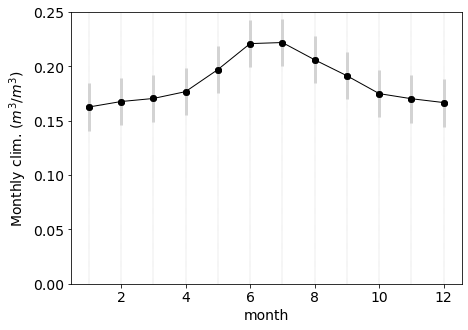

In [15]:
fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(7,5)) #width, height

for xline in range(1, 13):
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)

plt.plot(da_sm_lt_monClim_regAvg.month.values, da_sm_lt_monClim_regAvg.values, color="black", marker="o", linewidth=1)
plt.errorbar(da_sm_uncert_lt_monClim.month.values, da_sm_lt_monClim_regAvg.values, yerr=da_sm_uncert_lt_monClim_regAvg.values, fmt='o', color='black',
             ecolor='lightgrey', elinewidth=3, capsize=0)
plt.xlabel('month')
plt.ylabel('Monthly clim. ($m^3$/$m^3$)')
plt.ylim((0, 0.25))

fig.savefig(out_dir + 'ESACCI_sm_monClim_wUncert.png', bbox_inches='tight', dpi = 600)
fig.savefig(out_dir + 'ESACCI_sm_monClim_uUncert.pdf', bbox_inches='tight', format = 'pdf')

### Anomalies in % (to mention in the text)

In [45]:
anom_seasMean = da_sm_monAnom_regAvg.resample(time="QS-DEC").mean()
clim_seasMean = da_sm_lt_monClim_regAvg.sel(month = da_sm_monAnom_regAvg['time.month'].values).rename({'month':'time'})\
.assign_coords({'time':da_sm_monAnom_regAvg.time.values}).resample(time="QS-DEC").mean()

df_anom = pd.DataFrame({'season':anom_seasMean.time.values,
                        'anomaly (m3/m3)': np.round(anom_seasMean, 5).values,
                        'perc_anomaly (%)': np.round(anom_seasMean/clim_seasMean*100,1).values,
                       'climatology (m3/m3)': np.round(clim_seasMean, 5).values})
print(df_anom)

out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/seas_esacci_sm_anomalies.csv'
df_anom.to_csv(out_file)

       season  anomaly (m3/m3)  perc_anomaly (%)  climatology (m3/m3)
0  2016-12-01         -0.00404              -2.4              0.16563
1  2017-03-01         -0.00066              -0.4              0.18140
2  2017-06-01         -0.02373             -11.0              0.21630
3  2017-09-01         -0.01105              -6.2              0.17883
4  2017-12-01         -0.01073              -6.5              0.16563
5  2018-03-01         -0.02636             -14.5              0.18140
6  2018-06-01         -0.03848             -17.8              0.21630
7  2018-09-01         -0.01716              -9.6              0.17883
8  2018-12-01         -0.02656             -16.0              0.16563
9  2019-03-01         -0.01383              -7.6              0.18140
10 2019-06-01         -0.03450             -16.0              0.21630
11 2019-09-01         -0.04013             -22.4              0.17883
12 2019-12-01         -0.01656             -10.0              0.16563
13 2020-03-01       

In [46]:
anom_mon = da_sm_monAnom_regAvg
clim_mon = da_sm_lt_monClim_regAvg.sel(month = da_sm_monAnom_regAvg['time.month'].values).rename({'month':'time'}).assign_coords({'time':da_sm_monAnom_regAvg.time.values})

df_anom_mon = pd.DataFrame({'month':anom_mon.time.values,
                        'anomaly (m3/m3)': np.round(anom_mon, 5).values,
                        'perc_anomaly (%)': np.round(anom_mon/clim_mon*100,1).values,
                        'climatology (m3/m3)': np.round(clim_mon, 5).values})
print(df_anom_mon)
out_file_mon = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/mon_esacci_sm_anomalies.csv'
df_anom_mon.to_csv(out_file_mon)

        month  anomaly (m3/m3)  perc_anomaly (%)  climatology (m3/m3)
0  2016-12-15          0.00824               4.9              0.16669
1  2017-01-15          0.00397               2.4              0.16258
2  2017-02-15         -0.02433             -14.5              0.16763
3  2017-03-15          0.00106               0.6              0.17045
4  2017-04-15         -0.00000              -0.0              0.17674
5  2017-05-15         -0.00303              -1.5              0.19701
6  2017-06-15         -0.02496             -11.3              0.22093
7  2017-07-15         -0.02314             -10.4              0.22192
8  2017-08-15         -0.02310             -11.2              0.20604
9  2017-09-15         -0.04026             -21.0              0.19135
10 2017-10-15          0.01021               5.8              0.17492
11 2017-11-15         -0.00310              -1.8              0.17022
12 2017-12-15          0.00263               1.6              0.16669
13 2018-01-15       

## Daily data
#### Revisit later if required

In [ ]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/sm_data/'
sm_mon_file = 'esacci_monthly_1979_2020.nc'
sm_uncert_mon_file = 'esacci_sm_uncertainty_monthly_1979_2020.nc'

ds_sm = xr.open_dataset(data_dir + sm_mon_file)
ds_sm_uncert = xr.open_dataset(data_dir + sm_uncert_mon_file)

In [ ]:
# data for the drought period
time_slice = slice('2017-01-01', '2020-12-31')
da_sm = ds_sm['sm'].sel(time = time_slice)
da_sm_uncert = ds_sm_uncert['sm_uncertainty'].sel(time = time_slice)

# the monthly climatology from long-term data
time_slice = slice('1981-01-01', '2020-05-31')
da_sm_lt_monClim = ds_sm['sm'].sel(time = time_slice).groupby('time.month').mean('time')
da_sm_monAnom = da_sm.groupby('time.month') - da_sm_lt_monClim
da_sm_uncert_lt_monClim = ds_sm_uncert['sm_uncertainty'].sel(time = time_slice).groupby('time.month').mean('time')

## Ancillary datasets received with ESACCI

In [27]:
raw_data_dir = '/g/data/w97/ad9701/ESACCI/4_ancillary/'
ds_porosity = xr.open_dataset(raw_data_dir + 'ESACCI-SOILMOISTURE-POROSITY_V01.1.nc')
ds_topo = xr.open_dataset(raw_data_dir +  'ESACCI-SOILMOISTURE-TOPOGRAPHIC_COMPLEXITY_V01.1.nc')
ds_wetLand = xr.open_dataset(raw_data_dir +  'ESACCI-SOILMOISTURE-WETLAND_FRACTION_V01.1.nc')
ds_landmask = xr.open_dataset(raw_data_dir +  'ESA-CCI-SOILMOISTURE-LAND_AND_RAINFOREST_MASK-fv04.2.nc')
ds_vod = xr.open_dataset(raw_data_dir + 'AMSRE_D_MEAN_VOD_069_2002_2011.nc')

In [35]:
ds_porosity['porosity']

<xarray.DataArray 'porosity' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float32 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
Attributes:
    long_name:        Porosity
    units:            percent
    valid_range:      [  0. 100.]
    _CoordinateAxes:  lat lon

In [31]:
ds_topo

<xarray.Dataset>
Dimensions:                 (lon: 1440, lat: 720)
Coordinates:
  * lon                     (lon) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * lat                     (lat) float32 89.88 89.62 89.38 ... -89.62 -89.88
Data variables:
    topographic_complexity  (lat, lon) float32 ...
Attributes: (12/38)
    title:                      ESA CCI ECV SOILMOISTURE TOPGRAPHIC COMPLEXITY
    institution:                Vienna University of Technology, VU Universit...
    contact:                    cci_sm_contact@eodc.eu
    source:                     GTOPO30 (Global 30 Arc-Second Elevation Data ...
    history:                    2015-08-06 15:20:21 - product produced
    references:                 GTOPO30 (Global 30 Arc-Second Elevation Data ...
    ...                         ...
    sensor:                     N/A
    spatial_resolution:         25km
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    geospatial_lat_resolution:  0.25 degree
    geospatial_lon_resolution:  0.25 degree

In [32]:
ds_wetLand

<xarray.Dataset>
Dimensions:           (lon: 1440, lat: 720)
Coordinates:
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * lat               (lat) float32 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
Data variables:
    wetland_fraction  (lat, lon) float32 ...
Attributes: (12/38)
    title:                      ESA CCI ECV SOILMOISTURE WETLAND FRACTION
    institution:                Vienna University of Technology, VU Universit...
    contact:                    cci_sm_contact@eodc.eu
    source:                     Global Lakes and Wetlands Database (GLWD) lev...
    history:                    2015-08-06 15:28:21 - product produced
    references:                 Lehner, B., & Döll, P. (2004). Development an...
    ...                         ...
    sensor:                     N/A
    spatial_resolution:         25km
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    geospatial_lat_resolution:  0.25 degree
    geospatial_lon_resolution:  0.25 degree

In [33]:
ds_landmask

<xarray.Dataset>
Dimensions:     (lat: 720, lon: 1440)
Coordinates:
  * lat         (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon         (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables:
    crs         int32 ...
    gpi         (lat, lon) int32 ...
    cell        (lat, lon) int16 ...
    land        (lat, lon) int8 ...
    rainforest  (lat, lon) int8 ...
Attributes: (12/34)
    gpidirect:                  11
    geospatial_lon_min:         -180.0
    geospatial_lat_max:         90.0
    date_created:               20160518T000921Z
    geospatial_lat_min:         -90.0
    id:                         ESA-CCI-SOILMOISTURE-LAND_AND_RAINFOREST_MASK...
    ...                         ...
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    geospatial_lat_resolution:  0.25 degree
    geospatial_lon_resolution:  0.25 degree
    spatial_resolution:         25km
    shape:                      [1440  720]

In [40]:
ds_vod['vod']

<xarray.DataArray 'vod' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Attributes:
    long_name:  Vegetation Optical Depth Mean

In [37]:
ds_sm_sample = xr.open_dataset('/g/data/w97/ad9701/ESACCI/3_unzip/2020/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20201016000000-fv06.1.nc')
ds_sm_sample

<xarray.Dataset>
Dimensions:         (lat: 720, time: 1, lon: 1440)
Coordinates:
  * lat             (lat) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * time            (time) datetime64[ns] 2020-10-16
  * lon             (lon) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    sm              (time, lat, lon) float32 ...
    sm_uncertainty  (time, lat, lon) float32 ...
    flag            (time, lat, lon) float32 ...
    freqbandID      (time, lat, lon) float32 ...
    dnflag          (time, lat, lon) float32 ...
    mode            (time, lat, lon) float32 ...
    sensor          (time, lat, lon) float32 ...
    t0              (time, lat, lon) datetime64[ns] ...
Attributes: (12/42)
    title:                        ESA CCI Surface Soil Moisture COMBINED acti...
    institution:                  Technical University of Vienna (AUT); Vande...
    contact:                      cci_sm_contact@eodc.eu
    source:                       WARP 5.5R1.1/AMI-WS/ERS12 Level 2 Soil Mois...
    platform:                     Nimbus 7, DMSP, TRMM, AQUA, Coriolis, GCOM-...
    sensor:                       SMMR, SSM/I, TMI, AMSR-E, WindSat, AMSR2, S...
    ...                           ...
    geospatial_lon_units:         degrees_east
    geospatial_lat_resolution:    0.25 degree
    geospatial_lon_resolution:    0.25 degree
    spatial_resolution:           25km
    time_coverage_start_product:  19781101T000000Z
    time_coverage_end_product:    20201231T235959Z